In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [46]:
data=pd.read_csv('AirPassengers.csv')

data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [47]:
if data.isnull().values.any():
    data=data.dropna()
    print('Удалили пропуски')
else:
    print('Пропусков небыло')

Пропусков небыло


In [48]:
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')

In [49]:
data.set_index('Month', inplace=True)

In [50]:
if data.index.is_monotonic_increasing:
    print('Индекс монотонно возрастает.')
else:
    print('Нет монотонного возрастания индекса')

Индекс монотонно возрастает.


In [51]:
all_data=data
filtred_data=data['1952':'1957']


In [52]:
decomposition=seasonal_decompose(filtred_data, model='multiplicative')

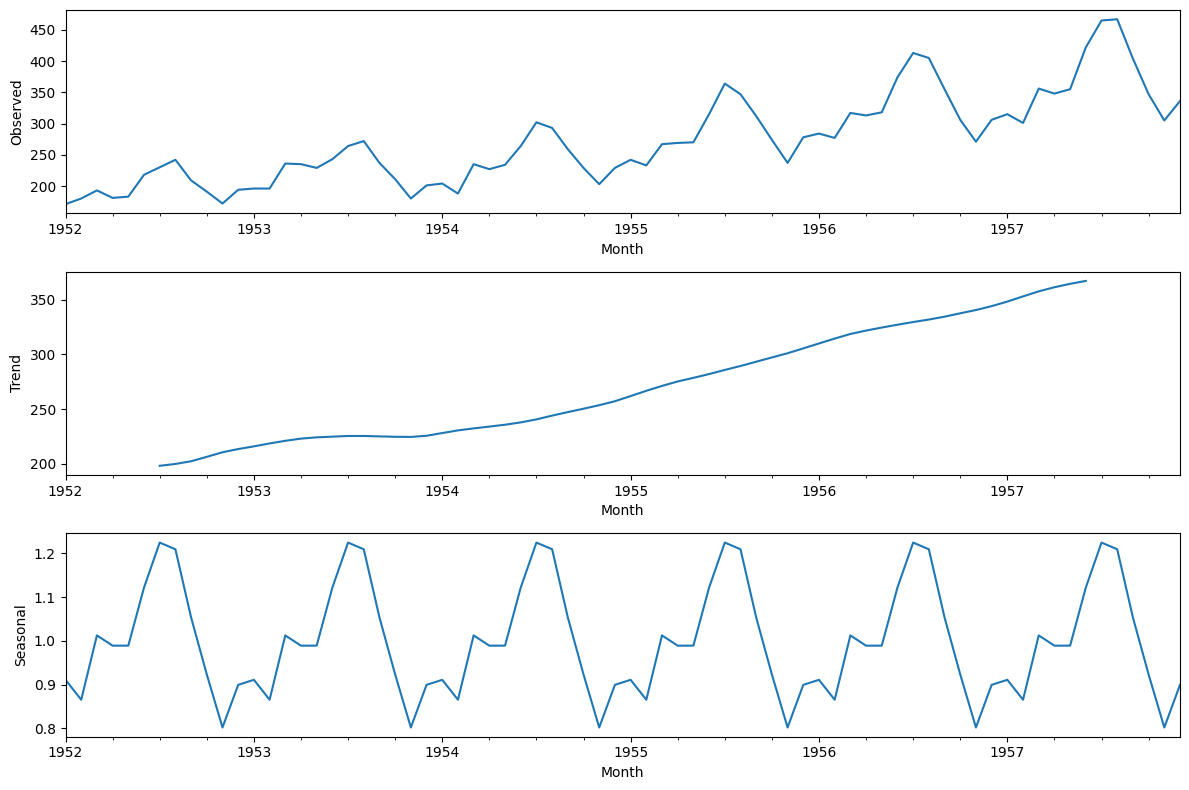

In [53]:
fig, (ax1, ax2, ax3)=plt.subplots(3,1,figsize=(12,8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
plt.tight_layout()
plt.show()


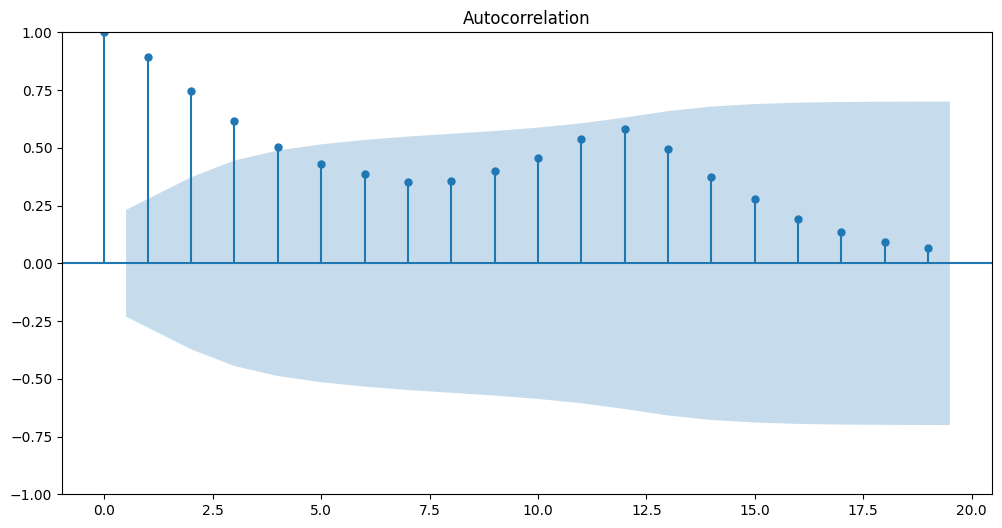

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(filtred_data, ax=ax)
plt.show()

График автокорреляции показывает положительную автокорреляцию на больших лагах, что часто свидетельствует о наличии тренда. На левых лагах, кратных 12, корреляция особенно высока, что дополнительно подтверждает наличие годовой сезонности.
В целом, временной ряд для данных о пассажирских перевозках не является стационарным из-за наличия положительного тренда и сезонности, что подтверждается и графиком автокорреляции.

In [55]:
def make_features(data, max_lag, max_rolling_mean_size):
    data['year']=data.index.year
    data['month']=data.index.month
    data['quarter']=data.index.quarter

    for lag in range(1, max_lag+1):
        data[f'lag_{lag}']=data['Passengers'].shift(lag)
    
    for rolling_mean_size in range(1, max_rolling_mean_size+1):
        data[f'rolling_mean_{rolling_mean_size}']=data['Passengers'].rolling(rolling_mean_size).mean()
        data[f'rolling_mean_{rolling_mean_size}']=data[f'rooling_mean_{rolling_mean_size}'].shift(rolling_mean_size)

    return data

    


In [56]:
data=filtred_data.rename(columns={'#Passengers':'Passengers'})

In [57]:
data

,Passengers
Month,
1952-01-01,171
1952-02-01,180
1952-03-01,193
1952-04-01,181
1952-05-01,183
...,...
1957-08-01,467
1957-09-01,404
1957-10-01,347


In [58]:
#data_with_features=make_features(data[['Passengers']].copy(),6,6)


In [59]:
def generate_features(data, lags, rolling_windows):
    df = data.copy()
    
    # Добавление календарных признаков
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    # Добавление лагов
    for lag in lags:
        df[f'lag_{lag}'] = df['Passengers'].shift(lag)
    
    # Добавление скользящих средних
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['Passengers'].shift().rolling(window=window).mean()
    
    # Удаление наблюдений с пропусками
    df.dropna(inplace=True)
    
    return df

In [60]:
lags = [1, 3, 6]
rolling_windows = [3, 6, 12]
df_features = generate_features(data, lags, rolling_windows)

In [61]:
df_features

,Passengers,month,quarter,lag_1,lag_3,lag_6,rolling_mean_3,rolling_mean_6,rolling_mean_12
Month,,,,,,,,,
1953-01-01,196,1,1,194.0,191.0,230.0,185.666667,206.333333,197.000000
1953-02-01,196,2,1,196.0,172.0,242.0,187.333333,200.666667,199.083333
1953-03-01,236,3,1,196.0,194.0,209.0,195.333333,193.000000,200.416667
1953-04-01,235,4,2,236.0,196.0,191.0,209.333333,197.500000,204.000000
1953-05-01,229,5,2,235.0,196.0,172.0,222.333333,204.833333,208.500000
1953-06-01,243,6,2,229.0,236.0,194.0,233.333333,214.333333,212.333333
1953-07-01,264,7,3,243.0,235.0,196.0,235.666667,222.500000,214.416667
1953-08-01,272,8,3,264.0,229.0,196.0,245.333333,233.833333,217.250000
1953-09-01,237,9,3,272.0,243.0,236.0,259.666667,246.500000,219.750000


In [62]:
train, test=train_test_split(df_features,shuffle=False, test_size=0.2)
train=train.dropna()


In [63]:
train_target=train['Passengers']
train_features=train.drop(['Passengers'], axis=1)
test_target=test['Passengers']
test_features=test.drop(['Passengers'],axis=1)


In [64]:
scaler=StandardScaler().fit(train_features)
train_features_norm=scaler.transform(train_features)
test_features_norm=scaler.transform(test_features)

In [65]:
model=LinearRegression()
model.fit(train_features_norm, train_target)

LinearRegression()

In [66]:
train_prediction=pd.Series(model.predict(train_features_norm))
train_prediction.index=train_features.index
test_prediction=pd.Series(model.predict(test_features_norm))
test_prediction.index=test_features.index

In [67]:
print('MAE обучающей выборки:', mean_absolute_error(train_target, train_prediction))
print('MAE тестовой выборки:', mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 14.731682581772949
MAE тестовой выборки: 20.670876711840446


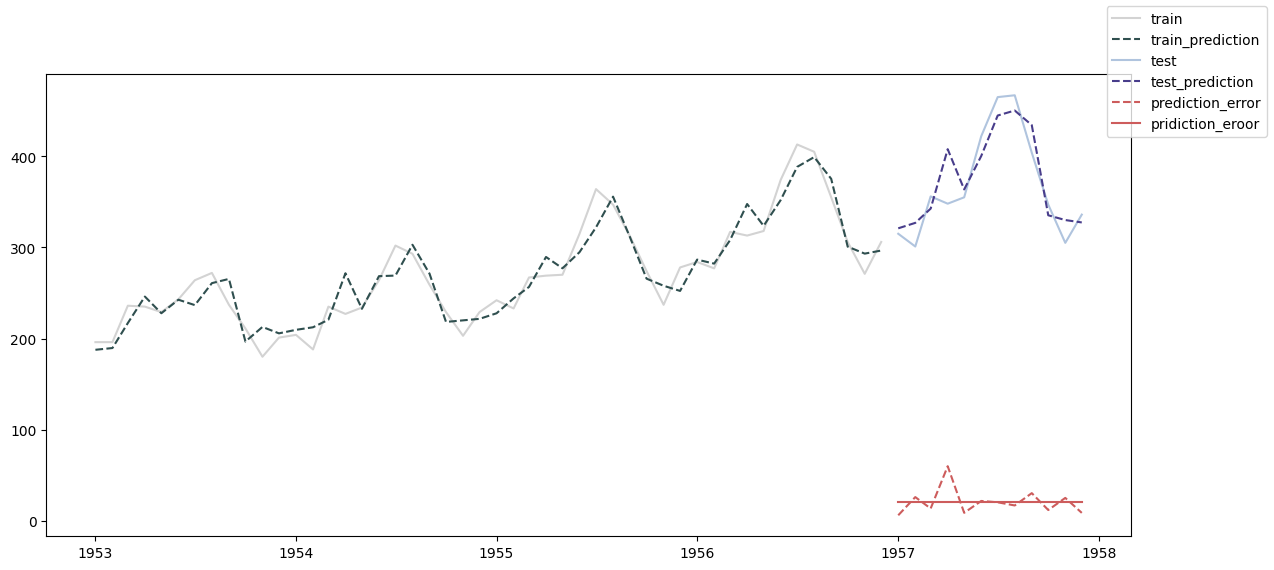

In [68]:
fig, ax = plt.subplots(1,1, figsize=[14,6])
error=abs(test['Passengers']-test_prediction)
error_mean=pd.Series([error.mean()]*error.shape[0])
error_mean.index=test.index
ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='dashed')
ax.plot(test_target, c="lightsteelblue", label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='dashed')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error')
ax.plot(error_mean, c='indianred',label='pridiction_eroor')
fig.legend()



In [71]:
data2=all_data['1957':'1960']
print(data2.index.min(), data2.index.max())
data2

1957-01-01 00:00:00 1960-12-01 00:00:00


,#Passengers
Month,
1957-01-01,315
1957-02-01,301
1957-03-01,356
1957-04-01,348
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404


In [74]:
data2=data2.rename(columns={'#Passengers':'Passengers'})

In [75]:

data_with_features=make_features(data2[['Passengers']].copy(), 6, 6)
data_with_features.head(10)

KeyError: 'rooling_mean_1'